# Cosmic Variance

**1. Theoretical Framework**

* **Cosmic Variance:** This refers to the inherent uncertainty in our understanding of the large-scale structure of the universe. Due to the finite size of our observable universe, we only have a limited sample of the cosmic density field. This leads to statistical fluctuations in the observed distribution of matter, even if our cosmological model is perfectly accurate.
* **Dark Matter Correlation Function:** This function describes how the density of dark matter is correlated at different spatial separations. It's a key ingredient in understanding the distribution of matter in the universe.
* **Galaxy Bias:** Galaxies are not perfectly tracers of the underlying dark matter distribution. Galaxy bias accounts for the fact that galaxies may preferentially form in regions of higher or lower dark matter density. 
* **Halomod:** This is a theoretical framework that describes the clustering of dark matter halos, which are the sites of galaxy formation. It provides a way to connect the properties of dark matter halos to the observed properties of galaxies.

**2. Computing Cosmic Variance**

1. **Calculate the Dark Matter Correlation Function:**
   - Use cosmological simulations or theoretical models (like the Halomod framework) to predict the dark matter correlation function, ξ_mm(r), as a function of separation (r).
2. **Incorporate Galaxy Bias:**
   - **Linear Bias:** For small-scale fluctuations, galaxy bias can often be approximated as a linear relationship:
      ξ_gg(r) = b^2 * ξ_mm(r) 
      where ξ_gg(r) is the galaxy-galaxy correlation function and 'b' is the galaxy bias parameter.
   - **Non-linear Bias:** On smaller scales, non-linear effects become important. These can be incorporated into the Halomod framework using more sophisticated bias models.
3. **Calculate the Variance:**
   - The cosmic variance associated with the galaxy-galaxy correlation function can be estimated by considering the variance of the underlying dark matter density field within the survey volume. 
   - This typically involves integrating the power spectrum of the density fluctuations over the relevant scales.

**3. Using Halomod**

* **Halomod provides a flexible framework for modeling the connection between dark matter halos and galaxies.**
* It allows you to:
    - Model the distribution of dark matter within halos (e.g., using the Navarro-Frenk-White profile).
    - Account for the occupation of halos by galaxies (how many galaxies reside in halos of different masses).
    - Incorporate various bias models to connect galaxy clustering to the underlying dark matter distribution.
* **To use Halomod for this calculation:**
    - Implement the necessary functions within the Halomod framework to calculate the galaxy-galaxy correlation function given the dark matter correlation function and the chosen bias model.
    - Use the Halomod framework to calculate the variance of the galaxy-galaxy correlation function within the survey volume.

**4. Important Considerations**

* **Survey Geometry:** The shape and size of the survey volume will significantly impact the level of cosmic variance.
* **Redshift Dependence:** Both the dark matter correlation function and galaxy bias can evolve with redshift.
* **Systematic Errors:** Be sure to carefully consider and account for potential systematic errors in your analysis, such as observational biases and uncertainties in cosmological parameters.

**Software Tools**

* **Python:** The Halomod framework is often implemented in Python, making it a convenient choice for these calculations.
* **Cosmological Simulation Codes:** Codes like GADGET, PKDGRAV, and others can be used to generate mock galaxy catalogs and directly measure the impact of cosmic variance.



In [19]:
import astropy.io.fits as fits
import numpy as np
from numpy import array

from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy import stats

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15
import treecorr


#import arviz as az
#import pandas as pd
import pymc as pm
from pymc import HalfCauchy, Model, Normal, sample

%matplotlib inline

import halomod as hm
import hmf

import astropy.io.fits as pyfits
import copy

import sys



In [20]:


# Define the path to the data directory relative to the current script
data_dir = os.path.join("/home/astro/manasoi7/Master_Thesis/DATA") 

# Define file names
cat_files = ["COSMOS_masked_cat.fits", "SN-C3_masked_cat.fits",  
             "SN-X3_masked_cat.fits", "SN-E2_masked_cat.fits"]

zm_files = ["Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits", 
            "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",  
            "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits", 
            "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits"]

rand_files = ["COSMOS_randoms_ugriz_trim_video.fits", 
              "SN-C3_randoms_ugriz_trim_video.fits",  
              "SN-X3_randoms_ugriz_trim_video.fits", 
              "SN-E2_randoms_ugriz_trim_video.fits"]

names = ['COSMOS', 'SN-C3', 'SN-X3', 'SN-E2']

# Create full file paths
cat_full_paths = [os.path.join(data_dir, f) for f in cat_files]
zm_full_paths = [os.path.join(data_dir, f) for f in zm_files]
rand_full_paths = [os.path.join(data_dir, f) for f in rand_files]

## from William's notebook

In [21]:
def get_w(cat, randoms):    
    data = treecorr.Catalog(ra=cat['ra'],dec=cat['dec'], 
                        ra_units='degrees', dec_units='degrees', npatch=50)
    rand = treecorr.Catalog(ra=randoms['ra'],dec=randoms['dec'], 
                        ra_units='degrees', dec_units='degrees')
    
    dd = treecorr.NNCorrelation(min_sep=0.001, max_sep=2., bin_size=0.2, sep_units='degrees', var_method='bootstrap')
    #var_method='jackknife')
    rr = treecorr.NNCorrelation(min_sep=0.001, max_sep=2., bin_size=0.2, sep_units='degrees')
    dd.process(data)
    rr.process(rand)
    theta = np.exp(dd.meanlogr)
    #print(dd[0],rr[0])
    
    dr = treecorr.NNCorrelation(min_sep=0.001, max_sep=2., bin_size=0.2, sep_units='degrees')
    dr.process(data, rand)
    
    w, varw = dd.calculateXi(rr=rr, dr=dr)
    #w.append(w_)
    #varw.append(varw_)
    
    return w, varw, theta, rr

In [27]:

current_dir = os.path.dirname(os.path.abspath(cat_files[1]))
print(f"Current directory: {current_dir}")

Current directory: /home/astro/manasoi7/Master_Thesis/Code


In [35]:


areas = np.array([1.24, 1.7, 1.52, 1.42])
nobj = []
w = []
varw = []
rr_pairs = []

for i in range(4):
    cat = pyfits.open(cat_full_paths[i])[1].data
    zm = pyfits.open(zm_full_paths[i])[1].data
    randoms = pyfits.open(rand_full_paths[i])[1].data

    
    # sort and match
    cat = cat[np.argsort(cat['id'])]
    zm = zm[np.argsort(zm['id'])]
    cat = cat[np.in1d(cat['id'],zm['id'])]
    zm = zm[np.in1d(zm['id'],cat['id'])]
    cat = cat[(cat['kNN_class']==1)&(cat['bdf_mag_dered_calib_i']<25.)&
              (zm['z']>0.5)&(zm['z']<=0.7)&(zm['SM']>10.0)&(zm['SM']<=11.5)]
    
    print(names[i], len(cat), len(cat)/areas[i])

    w_tmp, varw_tmp, theta, rr_ = get_w(cat, randoms)
    w.append(w_tmp)
    varw.append(varw_tmp)
    rr_pairs.append(rr_)
    nobj.append(len(cat))
    print(w_tmp)

nobj = np.array(nobj)

COSMOS 2642 2130.6451612903224
[ 1.33711544  0.99992376  2.10491587  1.54603132  1.38251373  0.50672662
  0.99532713  0.79454691  0.68836742  0.65853645  0.34537661  0.26908826
  0.20921998  0.21260618  0.05862568  0.13606424  0.09223145  0.09383325
  0.09594421  0.07217465  0.05138179  0.04289877  0.0505751   0.01633452
  0.03320293  0.02350642  0.00524398  0.01339344  0.00328439  0.00770728
 -0.00601213 -0.00790019 -0.01315307 -0.0114997  -0.01236859 -0.03164955
  0.04957819  0.1883305   0.57674165]
SN-C3 3510 2064.7058823529414
[ 2.53401313  2.04846625  1.50330793  1.37476038  1.04697728  1.27848663
  0.93511506  0.69736277  0.6588725   0.64778239  0.55147141  0.48882927
  0.42541083  0.29099221  0.28392921  0.192144    0.20271549  0.20325089
  0.17024077  0.11983067  0.10577192  0.08609999  0.06676592  0.06229485
  0.04775583  0.05771909  0.05552659  0.04036119  0.0242162   0.02169054
  0.01632298  0.01348417  0.00454619 -0.01355489 -0.0289863  -0.02029184
 -0.02423971  0.01736732 

In [36]:

print(np.average(nobj/areas))
nav = np.average(nobj/areas)

# need the bias to get the overdensity
b = 1.7
del_b = ((nobj/areas)/nav - 1) / b
print(del_b)

2096.646322808518
[ 0.00953872 -0.00896121  0.01902965 -0.01960716]


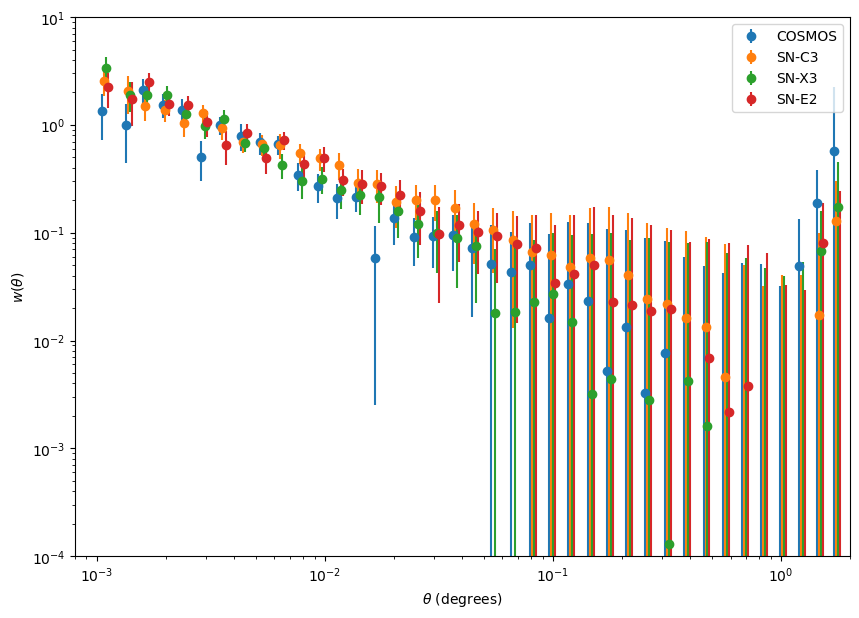

In [37]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
for i in range(4):
    ax.errorbar(theta*(0.98+0.02*i), w[i], yerr=np.sqrt(varw[i]), fmt='o', label=names[i])
#ax.errorbar(theta, w, yerr=varw, fmt='.', capsize=6, color='r')
#ax.plot(theta, a_best*(theta)**-0.8,'k:')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([8e-4,2.])
ax.legend()
#plt.savefig("Weird_X3_clustering.png")
plt.show()

In [39]:
x = theta
y = w[0] # COSMOS field
sigma = np.sqrt(varw[i])



with Model() as model:  
    # put our RR pair counts in tensor form    
    rr = pm.Data("rr", rr_pairs[0].npairs, dims="observation")

    # Define priors
    A = HalfCauchy("A", 0.5)
    delta = Normal('delta', -0.8, sigma=2.)
    IC = pm.math.sum(A * (x**delta) * rr) / pm.math.sum(rr)
    y_pred = A * (x**delta) - IC
    
    # Define likelihood
    likelihood = Normal("y", mu=y_pred, sigma=sigma, observed=y, dims="observation")

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(1000, tune=4000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, delta]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 7 seconds.


In [40]:
A_mean = np.median(idata.posterior["A"].values)
delta_mean = np.median(idata.posterior["delta"].values)
print(A_mean, np.median(idata.posterior["delta"].values))

0.005285898493828058 -0.8908486745904903


0.01072241377324435


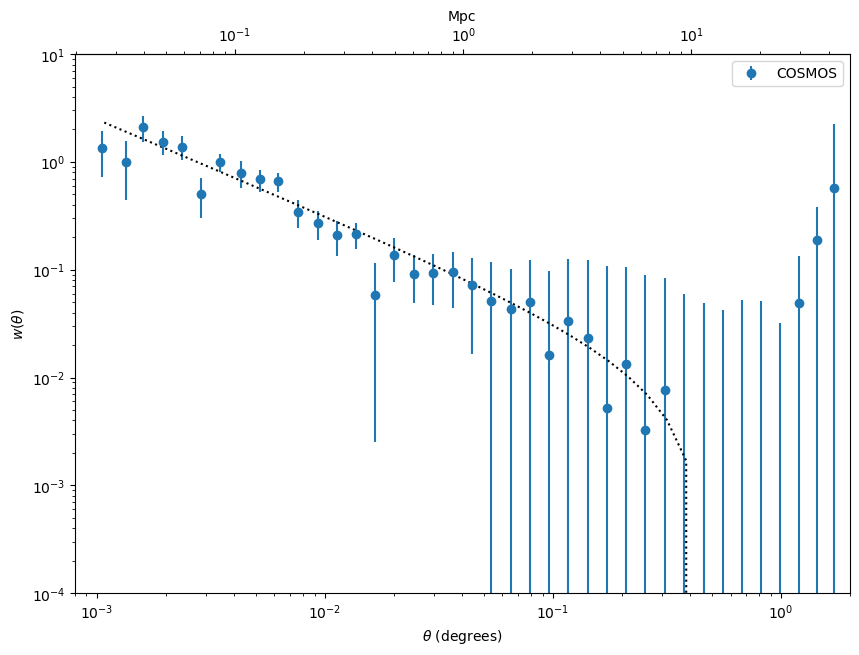

In [41]:
def w_th(A,delta,theta,rr):
    IC = np.sum(A * (theta**delta) * rr / np.sum(rr))
    print(IC)
    return A * (theta**delta) - IC

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
i=0
#for i in range(4):
ax.errorbar(theta*(0.98+0.02*i), w[i], yerr=np.sqrt(varw[i]), fmt='o', label=names[i])
#ax.errorbar(theta, w, yerr=varw, fmt='.', capsize=6, color='r')
ax.plot(theta, w_th(A_mean,delta_mean,theta,rr_pairs[0].npairs),'k:')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([8e-4,2.])
secax = ax.secondary_xaxis('top',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(0.6).value*60./1e3,
                                   lambda x: x*Planck15.arcsec_per_kpc_proper(0.6).value*1e3/3.6e3))
secax.set_xlabel(r'Mpc')
ax.legend()
#plt.savefig("Weird_X3_clustering.png")
plt.show()

In [42]:
nz = hm.integrate_corr.flat_z_dist(0.5,0.7)
gg = hm.integrate_corr.AngularCF(nz,nz,p_of_z=True,zmin=0.5,zmax=0.7,z=0.6)
gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}
gg.theta_min = np.min(theta)*np.pi/180
gg.theta_max = np.max(theta)*np.pi/180
gg.theta_num = len(theta)
#gg.hod_params

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


In [43]:
IC = []
for i in range(4):
    IC_tmp = np.sum(gg.angular_corr_gal*rr_pairs[i].npairs)/np.sum(rr_pairs[i].npairs)
    IC.append(IC_tmp)

print(IC)

[0.01917234531560334, 0.01525790579540128, 0.016688859758358106, 0.01633457935796227]


In [44]:
np.sum((gg.theta*180/np.pi)**(-0.8)*rr_pairs[i].npairs)/np.sum(rr_pairs[i].npairs) * 7.2e-3

0.012226389487899366

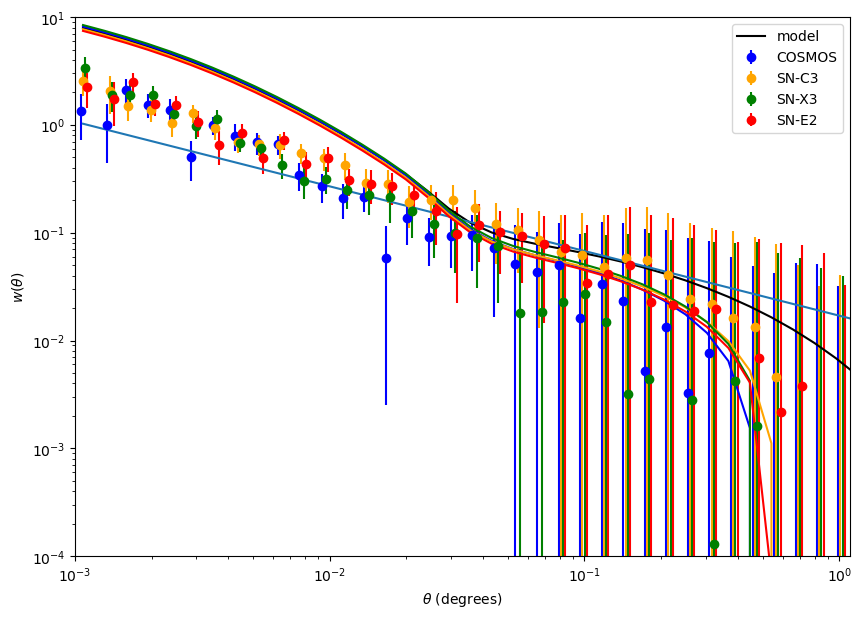

In [45]:
col = ['b', 'orange', 'green', 'red']
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
for i in range(4):
    ax.errorbar(theta*(0.98+0.02*i), w[i], yerr=np.sqrt(varw[i]), fmt='o', label=names[i], c=col[i])
#ax.errorbar(theta, w, yerr=varw, fmt='.', capsize=6, color='r')
#ax.plot(theta, a_best*(theta)**-0.8,'k:')
ax.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'k-', label='model')
ax.plot(theta, 0.017*theta**-0.6)

#ax.plot(gg.theta*180/np.pi, gg.angular_corr_matter, '--', c='gray')
for i in range(4):
    ax.plot(gg.theta*180/np.pi, np.exp(del_b[i]*(68/21))*(gg.angular_corr_gal-IC[i]), c=col[i])
#ax.plot(gg.theta*180/np.pi, 7.2e-3*(gg.theta*180/np.pi)**(-0.8)-0.012, '--', c='gray')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([1e-3,1.1])
ax.legend()
plt.savefig("wtheta_example.png")
plt.show()

In [46]:
print(gg.mean_tracer_den,gg.bias_effective_tracer)

0.0003057584675198279 1.7998801699636766


## now my own

In [47]:
config = {
    'min_sep':  0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'bootstrap'  # or 'jackknife'
}